<H1>Intro</h1>My girlfriend and I got into a debate because I thought white ducks and white geese were the same animals. After a quick Google search, I found out that they’re not. But rather than end it there, I decided to build an AI model to tell the difference between ducks, geese, and swans for me!

In [ ]:
# This block checks for internet connectivity in Kaggle notebooks, as you need an active connection to download necessary libraries and datasets.
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# Ensure we're using the latest versions of the fastai and duckduckgo_search libraries.
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

<h1>Searching and downloading images</h1>
To train the model, I need images of ducks, geese, and swans. Instead of manually collecting them, I wrote a function to search for these images online using DuckDuckGo.

In [46]:
#Load our ddg search, fast core, and vision learner items

from duckduckgo_search import DDGS #ddg_images (Deprecated 11-2023)
from fastcore.all import *
from fastai.vision.all import *

In [ ]:
# Function to search and download images from DuckDuckGo

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term,max_results=max_images)).itemgot('image')

In [62]:
# Test the function by searching for a duck image
results = search_images('duck', max_images=1)
results[0]

Searching for 'duck'


'http://upload.wikimedia.org/wikipedia/commons/7/74/White_domesticated_duck,_stretching.jpg'

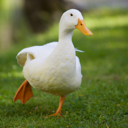

In [63]:
# Download the first duck image and preview it

from fastdownload import download_url

# Set the destination for the downloaded image
destination = 'duck.jpg'
download_url(results[0],destination,show_progress=False)

# Open the downloaded image and show it as a thumbnail
imageExample = Image.open(destination)
imageExample.to_thumb(128,128)

<h1>Preparing the dataset</h1>
Now that I have the search function working, I’ll download images for ducks, geese, and swans. The goal is to gather enough data to train a model that can distinguish between them.

In [13]:
# Define the categories (duck, goose, swan)
waterfowl_types = 'duck', 'goose', 'swan'
path = Path('waterfowl')

In [24]:
# Create a folder to store the images if it doesn't exist
if not path.exists():
    path.mkdir()

In [68]:
# Download images for each waterfowl category
for categories in waterfowl_types:
    categoryDestination = (path/categories)
    categoryDestination.mkdir(exist_ok=True)
    download_images(categoryDestination,urls=search_images(f'{categories} white'))

print('Image download complete.')

Searching for 'duck white'
Searching for 'goose white'
Searching for 'swan white'
Image download complete.


In [69]:
# Check if the images downloaded successfully
fns = get_image_files(path)
fns

(#416) [Path('waterfowl/duck/c5387296-dcf1-49cb-9340-50e4510b7333.jpg'),Path('waterfowl/duck/719a7ea3-1dbb-4b7e-a11b-34485d22b224.jpg'),Path('waterfowl/duck/83817b59-0bef-4067-b04c-1886d7839484.jpg'),Path('waterfowl/duck/64353e4a-5380-48a7-8e4f-10ebe8de9418.jpg'),Path('waterfowl/duck/edc38ce3-bfa5-4348-91a3-e0357b83f663.jpg'),Path('waterfowl/duck/dc94231d-8bfb-437c-9ef4-39c3b15381d9.jpg'),Path('waterfowl/duck/99ea8121-47de-4add-8b8f-628556365579.jpg'),Path('waterfowl/duck/5145d017-713f-4f98-ba66-deafa117242f.jpg'),Path('waterfowl/duck/d8c38101-c546-41ea-827c-5e2b5688f717.jpg'),Path('waterfowl/duck/a5027d25-3d8f-422f-ac47-30018485af42.jpg')...]

In [70]:
# Verify the images and remove any that are corrupted or invalid
failed = verify_images(fns)
failed

(#2) [Path('waterfowl/duck/82881e72-df9a-4af8-9242-a79f24861f6c.jpg'),Path('waterfowl/duck/809d373c-9f14-4058-a80e-c63323537217.jpg')]

In [71]:
# Remove failed images
failed.map(Path.unlink);
len(failed)

2

<H1>Building the model</h1>
Here’s where the AI model comes in. At first, I used a method called RandomResizedCrop (RRC) to randomly crop the images during training. However, I realized I didn’t want the model to rely on color differences when identifying animals. Instead, I wanted it to focus on their physical characteristics—so I pivoted to using grayscale images!



In [72]:
# Define the DataBlock for loading images
waterfowl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(128)
)

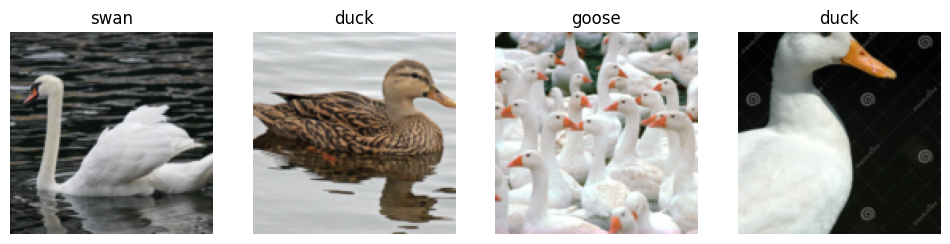

In [73]:
# Load the dataset
dls = waterfowl.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

<h1>Converting images to grayscale</h1>
To ensure the model doesn’t use color as a clue for differentiating the birds, I applied a grayscale transformation to the images.

In [75]:
# Create a custom transformation to convert images to grayscale
class GrayscaleTransform(Transform):
    def encodes(self, img: PILImage):  # Apply the transformation during encoding
        return img.convert("L")  # Convert the image to grayscale (L mode is for black-and-white)

In [76]:
# Define the DataBlock with the custom grayscale transformation
waterfowl_grayscale = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224), GrayscaleTransform()],  # Resize and apply grayscale
    batch_tfms=aug_transforms()  # Data augmentation
)

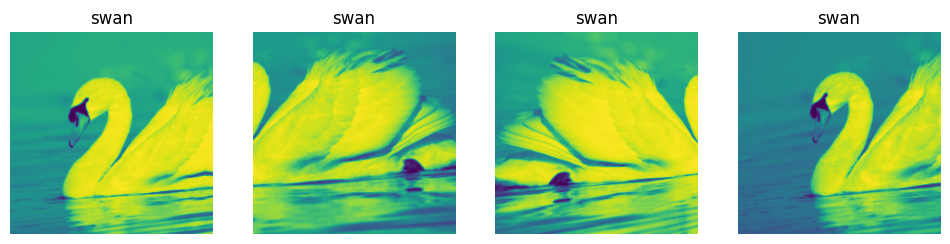

In [77]:
# Load the DataLoader with grayscale images
dls_grayscale = waterfowl_grayscale.dataloaders(path)
dls_grayscale.train.show_batch(max_n=4, nrows=1, unique=True)

<h1>Training the AI model</h1>
I trained a ResNet18 model using the grayscale images. This convolutional neural network is well-suited for image classification tasks.

In [78]:
# Train the learner using ResNet18 and grayscale images
learn = vision_learner(dls_grayscale, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.851434,0.729666,0.292683,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.830909,0.648621,0.256098,00:55
1,0.710885,0.588770,0.195122,00:55
2,0.578436,0.586708,0.182927,00:57
3,0.461672,0.782613,0.158537,00:56
4,0.386263,0.719662,0.134146,00:57
5,0.324786,0.582338,0.097561,00:56
6,0.286944,0.492080,0.085366,00:56
7,0.250527,0.406267,0.073171,00:56
8,0.219926,0.356418,0.060976,00:57
9,0.201133,0.328055,0.085366,00:56


<h1>Evaluating the model</h1>
After training the model, I evaluated its performance by visualizing the confusion matrix and analyzing where the model made mistakes. See, even the model was confused sometimes.

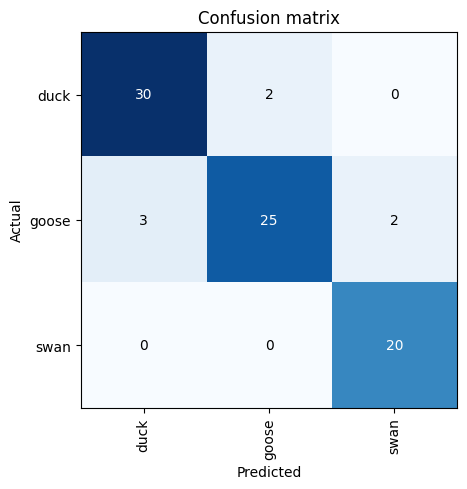

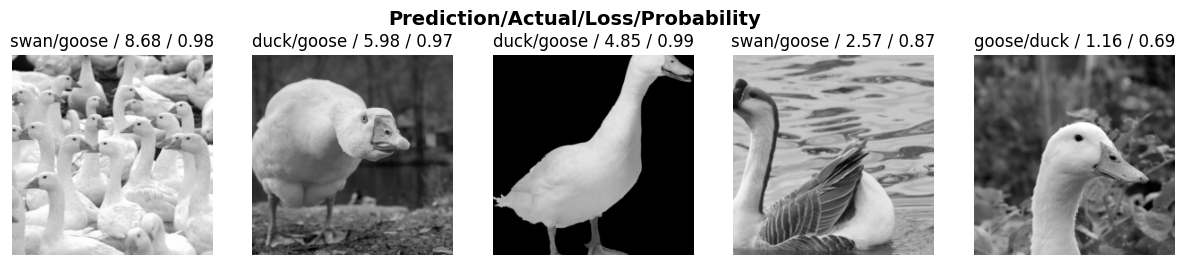

In [79]:
# Model interpretation: confusion matrix and top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

<h1>Making predictions</h1>
Finally, I tested the model by asking it to predict whether an image was of a duck, goose, or swan. The results were impressive!

In [80]:
# Make a prediction on the downloaded 'duck.jpg' image
is_duck, _, probs = learn.predict(PILImage.create('duck.jpg'))
print(f"This waterfowl is: {is_duck}.")
print(f"Probability it's a duck: {probs[0]:.4f}")

This waterfowl is: duck.
Probability it's a duck: 0.9999


<h1>Conclusion</h1>
In the end, my AI model confirmed what Google had already told me: white ducks and white geese are not the same animals. But now, I have a cool AI tool that can tell the difference between ducks, geese, and swans with great accuracy!